### IDENTIFY HIGH LATITUDE DUST IN A GIVEN MODIS IMAGERY

###### IMPORTING THE LIBRARIES

In this model, I have imported the packages that provide different functions and can build on one another.

In [1]:
#libraries to visualize the data 
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib

#data storing library
import numpy as np


#torch libraries
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset,random_split,DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.autograd import Function
from torch import optim
import torchvision.transforms as transforms
#handle image data
import imageio
from io import BytesIO

import random

#Evaluation metrics
import sklearn.metrics

#others
import os
import sys
from os.path import splitext
from os import listdir
from glob import glob

#parsing XML data
import xml.etree.ElementTree as et 
import re

#handle geospatial data
import geopandas as gp


# path to the directories
dir_img = 'data/imgs/'
dir_mask = 'data/masks/'
dir_checkpoint = 'checkpoints/'

###### DATA PREPROCESSING

In [4]:
#Normalize the data 
def normalize(img, mean, std):
    img = img/255.0
    img[0] = (img[0] - mean[0]) / std[0]
    img[1] = (img[1] - mean[1]) / std[1]
    img[2] = (img[2] - mean[2]) / std[2]
    img = np.clip(img, 0.0, 1.0)

    return img

class MyDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir,transform = None):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]

    def __len__(self):
        return len(self.ids)

    def preprocess(self, pil_img):
        pil_img = pil_img.resize((256, 256))
        img_nd = np.array(pil_img)
        img_nd = normalize(img_nd, mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans
    
    #applying cropping, image flipping and scaling to pre-process image:
    def transform(self, image, mask):
        # Resize the image
        resize = transforms.Resize(size=(256, 256))
                
        image = resize(image)
        mask = resize(mask)
        
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(256, 256))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
    
    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = glob(self.masks_dir + idx + '.*')
        img_file = glob(self.imgs_dir + idx + '.*')

        mask = Image.open(mask_file[0])
        img = Image.open(img_file[0])
        
        img, mask = self.transform(img, mask)
        to_pil_img = torchvision.transforms.ToPILImage()
        
        #preprocess the input data before it is fed into the network
        img = self.preprocess(to_pil_img(img))
        mask = self.preprocess(to_pil_img(mask))   
                
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor),
            'mask_file':mask_file,
            'img_file':img_file  
        }    


#### Splitting the dataset into training and validation data and defining data loaders 
In this section, the dataset is divided into training and validation sets in the ratio of 8:2. 
The data loaders for training and validation is defined which is later fed as an input to the model.

In [5]:
#creating the dataset
dataset = MyDataset(dir_img, dir_mask)

# splitting the dataset into training(0.8) and validation set(0.2)
lengths = [int(len(dataset)*0.8), int(len(dataset)*0.2)]
train, validation = random_split(dataset, lengths)

#defining the batch_size of the data
batchsize = 15

#defining the data loaders
train_loader = DataLoader(train, batch_size = batchsize, shuffle = True,num_workers = 8, pin_memory = True )
val_loader = DataLoader(validation, batch_size = lengths[1], shuffle = False,num_workers = 8, pin_memory = True, drop_last = True)


In [6]:
#list of images and masks of validation loader
my_images = []
my_img_masks = []
my_imgs_arr = []
my_mask_arr = []
for x,i in enumerate(val_loader):   
    my_images = i['img_file'][0]
    my_img_masks = i['mask_file'][0]
    my_imgs_arr = i['image']
    my_mask_arr = i['mask']


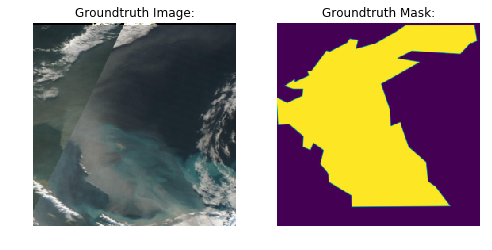

In [7]:
# visualize the original image and the mask
def visualize(number):
    fig = plt.figure(figsize=(8, 8))
    groundtruth = my_imgs_arr[number]
    groundtruth_mask = my_mask_arr[number]
    plt.subplot(1,2,1)
    plt.imshow(groundtruth.permute(1,2,0))
    plt.title("Groundtruth Image:")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(groundtruth_mask[0])
    plt.title("Groundtruth Mask:")
    plt.axis("off")
    plt.show()
    
visualize(np.random.randint(0,batchsize))

##### APPLYING ALGORITHM

In [8]:
#define the Unet model 
# (convolution => [BN] => ReLU) * 2
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Downscaling with maxpool then double conv
class Down(nn.Module):


    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Upscaling then double conv
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, 32)
        self.down5 = Down(32, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64// factor, bilinear)
        self.up5 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)

    def forward(self, x):
        x0 = self.inc(x)
        x1 = self.down5(x0)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.up5(x, x0)
        logits = self.outc(x)
        return logits

##### Define the Losses



In [9]:
#Defining dice coefficient    
def dice_coeff(inputs, targets, smooth = 1):        
    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  

    return dice

#Validation model evaluation
def eval_net(net, loader, device):
    net.eval()
    mask_type = torch.float32 if net.n_classes == 1 else torch.long
    n_val = len(loader)  # the number of batch
    tot = 0
    bce_loss = 0
    criterion = nn.BCEWithLogitsLoss()

    for batch in loader:
        imgs, true_masks = batch['image'], batch['mask']
        imgs = imgs.to(device=device, dtype=torch.float32)
        true_masks = true_masks.to(device=device, dtype=mask_type)

        with torch.no_grad():
            mask_pred = net(imgs)
            pred = nn.functional.sigmoid(mask_pred)
            pred = (pred > 0.5).float()
            tot += dice_coeff(pred, true_masks).item()
            bce_loss += criterion(pred, true_masks).item()
            
    net.train()
    return tot / n_val, bce_loss / n_val

In [10]:
train_loss_arr = []
val_loss_arr = []
train_accuracy_arr = []
val_accuracy_arr = []
best_accuracy = 0

def train_net(net, device, epochs=10, batch_size=batchsize, lr=0.01, save_cp=True):
    # Using Adam optimizer 
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-8)
    #loss function
    criterion = nn.BCEWithLogitsLoss()
    global best_accuracy
    global best_model_path
    for epoch in range(epochs):
        net.train()
        train_bce_loss = 0
        tot_dice_coeff = 0
        
        for batch in train_loader:
            imgs = batch['image']
            true_masks = batch['mask']

            imgs = imgs.to(device=device, dtype=torch.float32)
            mask_type = torch.float32 if net.n_classes == 1 else torch.long
            true_masks = true_masks.to(device=device, dtype=mask_type)

            masks_pred = net(imgs)
            loss = criterion(masks_pred, true_masks)
            train_bce_loss += loss.item()
            pred = nn.functional.sigmoid(masks_pred)
            pred = (pred > 0.5).float()
            tot_dice_coeff += dice_coeff(pred, true_masks).item()
            
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(net.parameters(), 0.1)
            optimizer.step()
        
        train_loss_arr.append(train_bce_loss / len(train_loader))
        train_accuracy_arr.append(tot_dice_coeff / len(train_loader))
        val_accuracy, val_bce_loss = eval_net(net, val_loader, device) 
        val_loss_arr.append(val_bce_loss)
        val_accuracy_arr.append(val_accuracy)
        
        print('Epoch: {} \nTraining: Training Loss: {:.5f} \tTraining Accuracy:{:.5f} \nValidation: Validation Loss: {:.5f} \tValidation Accuracy:{:.5f}'.format(epoch, train_bce_loss / len(train_loader), 
              tot_dice_coeff / len(train_loader), val_bce_loss, val_accuracy))
            
        if save_cp:
            try:
                os.mkdir(dir_checkpoint)
            except OSError:
                pass
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model_path = dir_checkpoint + f'CP_epoch{epoch + 1}.pth'
                torch.save(net.state_dict(),best_model_path)
    print('Best Model path after Training ',best_model_path)


if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = UNet(n_channels=3, n_classes=1, bilinear=True)
    net.to(device=device)

    try:
        train_net(net=net, epochs=35, batch_size=15, lr=0.0001, device=device)
    except KeyboardInterrupt:
        torch.save(net.state_dict(), 'INTERRUPTED.pth')
        try:
            sys.exit(0)
        except SystemExit:
            os._exit(0)

/home/CS/sh0143/.conda/envs/Shwetha/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0 
Training: Training Loss: 0.65553 	Training Accuracy:0.63633 
Validation: Validation Loss: 0.90839 	Validation Accuracy:0.57638
Epoch: 1 
Training: Training Loss: 0.55510 	Training Accuracy:0.72976 
Validation: Validation Loss: 0.90840 	Validation Accuracy:0.57637
Epoch: 2 
Training: Training Loss: 0.51515 	Training Accuracy:0.75920 
Validation: Validation Loss: 0.90838 	Validation Accuracy:0.57639
Epoch: 3 
Training: Training Loss: 0.49746 	Training Accuracy:0.77064 
Validation: Validation Loss: 0.86318 	Validation Accuracy:0.60599
Epoch: 4 
Training: Training Loss: 0.47383 	Training Accuracy:0.78223 
Validation: Validation Loss: 0.72925 	Validation Accuracy:0.71264
Epoch: 5 
Training: Training Loss: 0.46338 	Training Accuracy:0.78760 
Validation: Validation Loss: 0.65623 	Validation Accuracy:0.78361
Epoch: 6 
Training: Training Loss: 0.45875 	Training Accuracy:0.78817 
Validation: Validation Loss: 0.64081 	Validation Accuracy:0.80152
Epoch: 7 
Training: Training Loss: 0.4453

#### Plot the Training Vs Validation loss

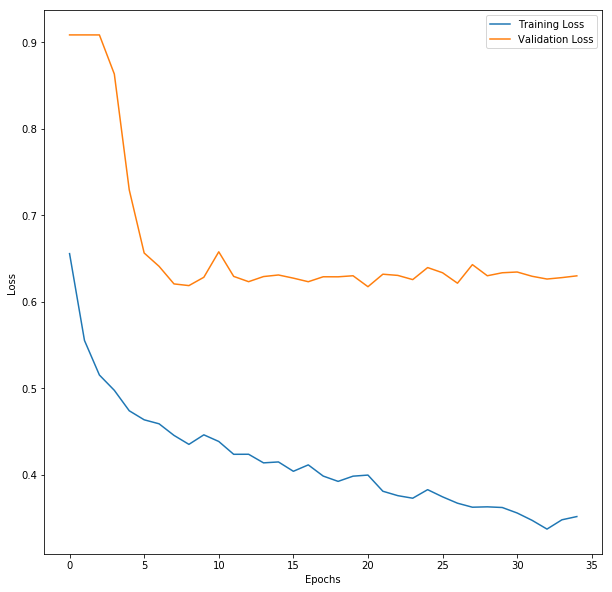

In [11]:
# loss
f = plt.figure(figsize=(10, 10))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss_arr, label='Training Loss')
plt.plot(val_loss_arr, label='Validation Loss')
plt.legend()
plt.show()


#### Predict the images




In [12]:
import glob
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()

    img = torch.from_numpy(MyDataset.preprocess(0,full_img))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)
        probs = torch.sigmoid(output)

        probs = probs.squeeze(0)
        tf = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToPILImage(),
                torchvision.transforms.Resize((full_img.size[1],full_img.size[0])),
                torchvision.transforms.ToTensor()
            ]
        )

        probs = tf(probs.cpu())
        full_mask = probs.squeeze().cpu().numpy()

    return full_mask > out_threshold


def get_output_filenames(out_files):
    op_files = []
    for f in out_files:
        pathsplit = os.path.split(f)
        op_files.append('tests/validated_pred_mask/'+pathsplit[1])

    return op_files

def get_input_filenames(in_files):
    in_files = []
    for f in in_files:
        pathsplit = os.path.split(f)
        op_files.append('tests/validated_src_mask/'+pathsplit[1])

    return in_files

def mask_to_image(mask):
    return Image.fromarray((mask * 255).astype(np.uint8))


        
if __name__ == "__main__":
    in_files = sorted(my_images)
    out_files = sorted(get_output_filenames(my_img_masks))
    save_in_files = sorted(my_img_masks)
    
    for f in glob.glob('tests/validated_src_mask/*'):
        os.remove(f)
    for f in glob.glob('tests/validated_pred_mask/*'):
        os.remove(f)
    for f in glob.glob('tests/validated_original_image/*'):
        os.remove(f)
    
        
    net = UNet(n_channels=3, n_classes=1)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device=device)
    #Using the best model from training
    #net.load_state_dict(torch.load('checkpoints/CP_epoch12.pth', map_location=device))
    net.load_state_dict(torch.load(best_model_path, map_location=device))

    for i, fn in enumerate(save_in_files):
        img = Image.open(fn).resize((256,256))
        img.save('tests/validated_src_mask/'+os.path.split(fn)[1])
    
        
    for i, fn in enumerate(in_files):
        img = Image.open(fn).resize((256,256))
        img.save('tests/validated_original_image/'+os.path.split(fn)[1])

        mask = predict_img(net=net,
                           full_img=img,
                           scale_factor=0.5,
                           out_threshold=0.5,
                           device=device)
        
        out_fn = out_files[i]
        result = mask_to_image(mask)
        result.save(out_files[i])

In [13]:
confusion_matrix_colors = {
    "tp": (0, 255, 255),  # cyan
    "fp": (255, 0, 255),  # magenta
    "fn": (255, 255, 0),  # yellow
    "tn": (131, 0, 0)  # Red
}

#creating the folders for validation images list, masks lists, and predicted mask list
src_mask_list = ['tests/validated_src_mask/' + i for i in os.listdir( 'tests/validated_src_mask') if not os.path.isdir('tests/validated_src_mask/' + i)]
pred_mask_list = ['tests/validated_pred_mask/' + i for i in os.listdir( 'tests/validated_pred_mask/') if not os.path.isdir('tests/validated_pred_mask/' + i)]
src_original_list = ['tests/validated_original_image/' + i for i in os.listdir( 'tests/validated_original_image/') if not os.path.isdir('tests/validated_original_image/' + i)]


# Sort the list 
src_mask_list = sorted(src_mask_list)
pred_mask_list = sorted(pred_mask_list)
src_original_list = sorted(src_original_list)


###### Grayscale Image Segmentation And Validation

In [14]:
#assert the list with unique elements
def _assert_valid_lists(groundtruth_list, predicted_list):
    
    assert len(groundtruth_list) == len(predicted_list)
    for unique_element in np.unique(groundtruth_list).tolist():
        assert unique_element in [0, 1]

#function to predict class 0 as class 1 (FN)
def _all_class_0_predicted_as_class_1(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == [0] and np.unique(predicted_list).tolist() == [1]

#function to predict class 1 as class 1 (TP)
def _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == np.unique(predicted_list).tolist() == [1]

#function to predict class 0 as class 0 (TN)
def _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == np.unique(predicted_list).tolist() == [0]

#function to predict class 1 as class 0 (FP)
def _all_class_1_predicted_as_class_0(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == [1] and np.unique(predicted_list).tolist() == [0]


#function to calculate the confusion matrix elements 
def get_confusion_matrix_elements(groundtruth_list, predicted_list):

    _assert_valid_lists(groundtruth_list, predicted_list)

    #The condition satisfies to be TP
    if _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        tn, fp, fn, tp = 0, 0, 0, np.float64(len(groundtruth_list))

    #The condition satisies to be TN
    elif _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        tn, fp, fn, tp = np.float64(len(groundtruth_list)), 0, 0, 0

    else:
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth_list, predicted_list).ravel()
        tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp



#Function to calculate F1 Score
def get_f1_score(groundtruth_list, predicted_list):

    _assert_valid_lists(groundtruth_list, predicted_list)
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)

    if _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        f1_score = 1
    elif _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        f1_score = 1
    else:
        f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score

#Function to calculate Recall
def get_recall(groundtruth_list, predicted_list):

    _assert_valid_lists(groundtruth_list, predicted_list)
   # tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)

    if _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        recall = 1
    elif _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        recall = 1
    else:
        recall = tp /(tp + fn)

    return recall

#Function to calculate Precision
def get_precision(groundtruth_list, predicted_list):
    
    _assert_valid_lists(groundtruth_list, predicted_list)
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)

    if _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        precision = 1
    elif _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        precision = 1
    else:
        precision = tp /(tp + fp)

    return precision


#Function to calculate accuracy
def get_accuracy(groundtruth_list, predicted_list):
    
    _assert_valid_lists(groundtruth_list, predicted_list)
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total

    return accuracy

#Function to calculate validation_metrics
def get_validation_metrics(groundtruth_list, predicted_list):

    _assert_valid_lists(groundtruth_list, predicted_list)
    validation_metrics = {}

    validation_metrics["accuracy"] = get_accuracy(groundtruth_list, predicted_list)
    validation_metrics["f1_score"] = get_f1_score(groundtruth_list, predicted_list)
    validation_metrics["precision"] = get_precision(groundtruth_list, predicted_list)
    validation_metrics["recall"] = get_recall(groundtruth_list, predicted_list)

    return validation_metrics

# VALIDATION VISUALIZATION

# Confusion matrix overlay masks where TP, FP, FN, TN columns in the masks are in different colors
def get_confusion_matrix_intersection_mats(groundtruth, predicted):
    confusion_matrix_arrs = {}

    groundtruth_inverse = np.logical_not(groundtruth)
    predicted_inverse = np.logical_not(predicted)

    confusion_matrix_arrs["tp"] = np.logical_and(groundtruth, predicted)
    confusion_matrix_arrs["tn"] = np.logical_and(groundtruth_inverse, predicted_inverse)
    confusion_matrix_arrs["fp"] = np.logical_and(groundtruth_inverse, predicted)
    confusion_matrix_arrs["fn"] = np.logical_and(groundtruth, predicted_inverse)

    return confusion_matrix_arrs

# Function to calculate confusion_matrix_overlaid_mask
def get_confusion_matrix_overlaid_mask(image, groundtruth, predicted, colors):
    
    alpha = 0.3
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    masks = get_confusion_matrix_intersection_mats(groundtruth, predicted)
    color_mask = np.zeros_like(image)

    for label, mask in masks.items():
        color = colors[label]
        mask_rgb = np.zeros_like(image)
        mask_rgb[mask != 0] = color
        color_mask += mask_rgb

    return cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)


Cyan - TP
Magenta - FP
Yellow - FN
Red - TN


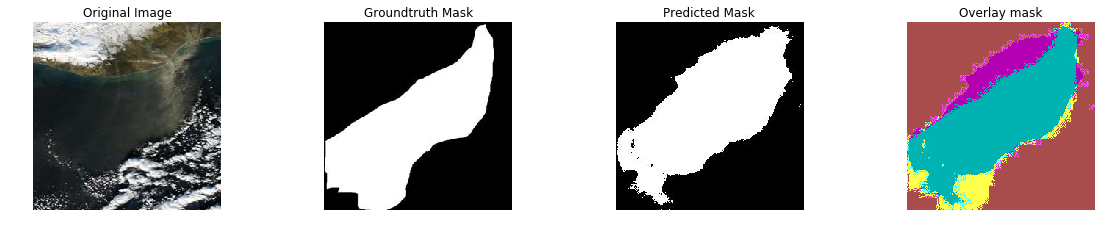

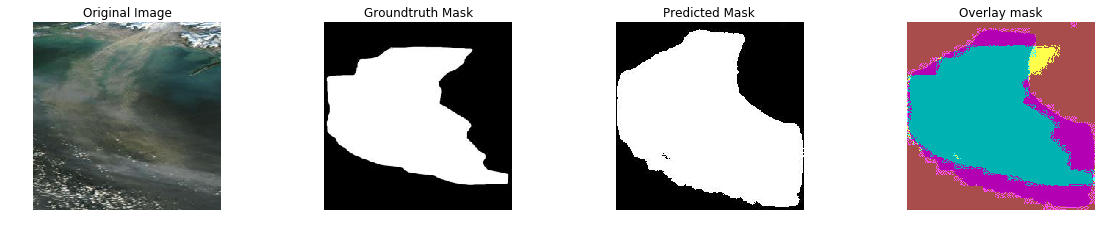

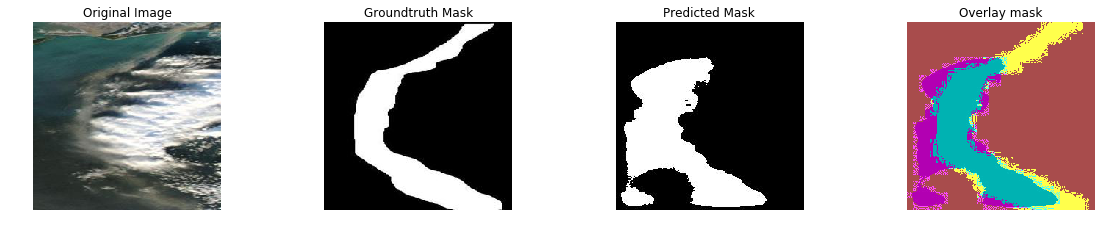

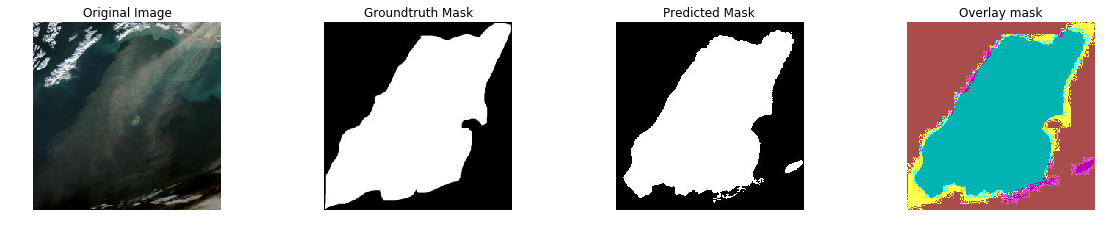

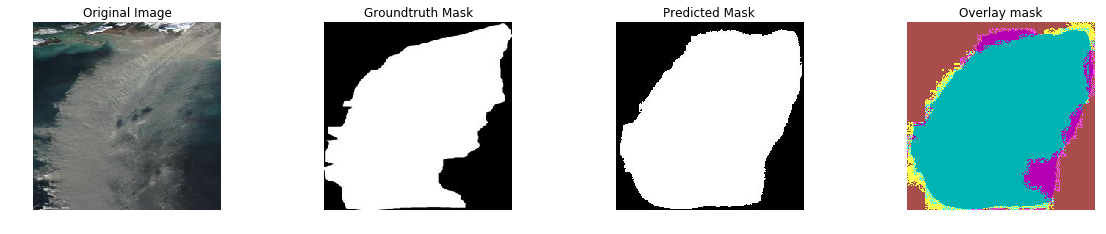

In [19]:
import math
f1score = 0
accuracy = 0
recall = 0
precision = 0
print("Cyan - TP")
print("Magenta - FP")
print("Yellow - FN")
print("Red - TN")
total = 5
for i in range(total):
    fig = plt.figure(figsize=(20, 20))
    groundtruth = imageio.imread(src_mask_list[i])
    predicted = imageio.imread(pred_mask_list[i])

    # LOADING AND VISUALIZING DATA
    grayscale = imageio.imread(pred_mask_list[i])
    #grayscale = 255 - grayscale
    ground_truth = imageio.imread(src_mask_list[i])
    original_img = imageio.imread(src_original_list[i])


    number_foreground_pixels = np.sum(ground_truth == 255)
    number_background_pixels = np.sum(ground_truth == 0)

    groundtruth_scaled = ground_truth // 255
    predicted_scaled = predicted // 255

    groundtruth_list = (groundtruth_scaled).flatten().tolist()
    predicted_list = (predicted_scaled).flatten().tolist()

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    validation_metrics = get_validation_metrics(groundtruth_list, predicted_list)
    f1score += validation_metrics['f1_score']
    accuracy += validation_metrics['accuracy']
    precision += validation_metrics['precision']
    recall += 0 if math.isnan(validation_metrics['recall']) else validation_metrics['recall']  

    validation_mask = get_confusion_matrix_overlaid_mask(255 - grayscale, ground_truth, predicted,
                                                         confusion_matrix_colors)

    ax1 = fig.add_subplot(5, 4, 3)
    ax1.imshow(grayscale, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    #ax1.show()
    
    ax2 = fig.add_subplot(5, 4, 4)
    ax2.imshow(validation_mask)
    plt.axis('off')
    plt.title("Overlay mask")
    #ax2.show()

    ax3 = fig.add_subplot(5, 4, 2)
    ax3.imshow(ground_truth, cmap='gray')
    plt.title("Groundtruth Mask")
    plt.axis("off")
    #ax3.show()
    
    ax4 = fig.add_subplot(5, 4, 1)
    ax4.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")
    #ax3.show()


In [16]:
import math
f1score = 0
accuracy = 0
recall = 0
precision = 0

total = len(val_loader)
for i in range(total):
    #fig = plt.figure(figsize=(20, 20))
    groundtruth = imageio.imread(src_mask_list[i])
    predicted = imageio.imread(pred_mask_list[i])

    # LOADING AND VISUALIZING DATA
    grayscale = imageio.imread(pred_mask_list[i])
    #grayscale = 255 - grayscale
    ground_truth = imageio.imread(src_mask_list[i])
    original_img = imageio.imread(src_original_list[i])


    number_foreground_pixels = np.sum(ground_truth == 255)
    number_background_pixels = np.sum(ground_truth == 0)

    groundtruth_scaled = ground_truth // 255
    predicted_scaled = predicted // 255

    groundtruth_list = (groundtruth_scaled).flatten().tolist()
    predicted_list = (predicted_scaled).flatten().tolist()

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    validation_metrics = get_validation_metrics(groundtruth_list, predicted_list)
    f1score += validation_metrics['f1_score']
    accuracy += validation_metrics['accuracy']
    precision += validation_metrics['precision']
    recall += 0 if math.isnan(validation_metrics['recall']) else validation_metrics['recall']     
    
print('Average Accuracy->', accuracy/total)
print('Average Precision->', precision/total)
print('Average Recall->', recall/total)
print('Average F1score->', f1score/total)


Average Accuracy-> 0.847808837890625
Average Precision-> 0.7580752515563212
Average Recall-> 0.8361186682212722
Average F1score-> 0.7951866606431476
